# Comparing results with baseline and chance level

In this notebook, we present how to **compare** the **statistical performance of a
model** to a **minimal baseline**.

Indeed, in the previous notebook, we compared the test error by
taking into account the target distribution. A **good practice** is to **compare**
the **test error** with a **dummy baseline** and the **chance level**. In
regression, we could use the **`DummyRegressor`** and **predict the mean target**
without using the data. The **chance level** can be determined by **permuting the
labels** and check the difference of result.

Let's **conduct an experiment** and **compute** the **score of a model** and the **two baselines**. We start by loading the **California housing dataset**.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

Across all evaluations, we use a **`ShuffleSplit` cross-validation**.

In [2]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

We start by running the **cross-validation for the decision tree
regressor** which is our model of interest. Besides, we will store the
test error in a pandas series.

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
result_regressor = cross_validate(regressor, data, target,
                                  cv=cv, scoring="neg_mean_absolute_error",
                                  n_jobs=-1)

errors_regressor = pd.Series(-result_regressor["test_score"],
                             name="Regressor error")
errors_regressor

0     47.484587
1     46.853196
2     44.429401
3     43.541756
4     47.573179
5     44.495194
6     44.278601
7     44.333666
8     44.829496
9     44.770120
10    46.790087
11    46.207622
12    45.512417
13    45.697331
14    46.886691
15    44.135167
16    46.233260
17    46.295145
18    45.456510
19    47.201399
20    43.257430
21    45.655078
22    45.317894
23    46.905178
24    46.312568
25    45.738342
26    44.468507
27    46.444688
28    45.594125
29    47.476667
Name: Regressor error, dtype: float64

Then, we evaluate our first **baseline** via the **dummy
regressor**. This dummy regressor's **prediction on the target is the mean of the training set**. Therefore, the dummy regressor will never use any
information regarding the data `target`.

In [4]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
result_dummy = cross_validate(dummy, data, target,
                              cv=cv, scoring="neg_mean_absolute_error",
                              n_jobs=-1)
errors_dummy = pd.Series(-result_dummy["test_score"], name="Dummy error")
errors_dummy

0     90.713153
1     90.539353
2     91.941912
3     90.213912
4     92.015862
5     90.542490
6     89.757566
7     92.477244
8     90.947952
9     91.991373
10    92.023571
11    90.556965
12    91.539567
13    91.185225
14    92.298971
15    91.084639
16    90.984471
17    89.981744
18    90.547140
19    89.820219
20    91.768721
21    92.305556
22    90.503017
23    92.147974
24    91.386320
25    90.815660
26    92.216574
27    90.107460
28    90.620318
29    91.165331
Name: Dummy error, dtype: float64

Finally, we evaluate the statistical performance of the **second baseline**.
This baseline provides the **statistical performance of the chance level**.
Indeed, we **train a decision tree on some training data** and **evaluate the
same tree on data** where the **target vector has been randomized**.

In [5]:
from sklearn.model_selection import permutation_test_score

regressor = DecisionTreeRegressor()
score, permutation_score, pvalue = permutation_test_score(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error",
    n_jobs=-1, n_permutations=30)
errors_permutation = pd.Series(-permutation_score, name="Permuted error")

In [6]:
pvalue

0.03225806451612903

Finally, we **plot the test errors for the two baselines and the
actual regressor**.

In [7]:
final_errors = pd.concat([errors_regressor, errors_dummy, errors_permutation],
                         axis=1)
final_errors

,Regressor error,Dummy error,Permuted error
0,47.484587,90.713153,128.946911
1,46.853196,90.539353,129.243758
2,44.429401,91.941912,129.067795
3,43.541756,90.213912,128.956908
4,47.573179,92.015862,128.721844
5,44.495194,90.542490,129.358476
6,44.278601,89.757566,130.103717
7,44.333666,92.477244,128.959787
8,44.829496,90.947952,128.979591
9,44.770120,91.991373,129.318438


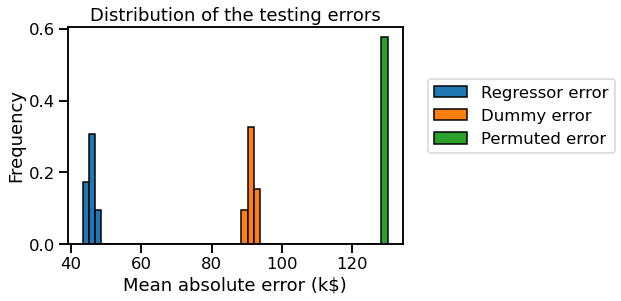

In [9]:
import matplotlib.pyplot as plt

final_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

We see that even if the **statistical performance of our model**, the decision tree model, is far from
being good, it is **better than** the two **baselines**. Besides, we see that the
**dummy regressor** is **better than** a **chance level regressor**.

**In practice**, using a **dummy regressor might be sufficient as a baseline**.
Indeed, to obtain a reliable estimate the permutation of the target should
be repeated and thus this method is costly. However, it gives the true
chance level.